# Fine Grain Image Classification
> Creating a fine grain image classifier - Pet Breeds!

- toc: true 
- badges: true
- comments: true
- hide: true
- author: Isaac Flath
- categories: [Neural Networks, Image Classification]

# Intro

For this post, I am going to make a modification to the loss function.  The goal will be to weight losses differently.

In this blog we are going to do an image classification to take pet pictures and predict the breed.  Normally, each class is treated the same when calculating the loss function.  In this post I will explore a change to take into account weighting classes differently. For example, If a picture is a maincoon, predicting a maincoon (wrong type of cat) is less egregious of an error than predicting pitbull.  I want my loss function to reflect this.

I am going to skim over loading the data and training the model, feel free to see my Fine Grain Image Classifier post from Jun-27-2020 if you want more detail on those aspect.

# Setup

### Library Import and Dataset Download

In [10]:
from fastai2.vision.all import *

seed = 42

# Download and get path for dataseet
path = untar_data(URLs.PETS) #Sample dataset from fastai2
img = (path/'images').ls()[0]

In [11]:
def accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = flatten_check(inp.argmax(dim=axis), targ)
    return (pred == targ).float().mean()

def accuracy_single(inp, targ, axis=-1):
    temp = [torch.argmax(x) for x in inp]
    
    new_inp = tensor([(x > 11).int() for x in temp])    
    new_targ = tensor([(x > 11).int() for x in targ])

    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    #pred,targ = flatten_check(inp.argmax(dim=axis), targ)
    return (new_inp == new_targ).float().mean()

In [12]:
pets = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter= RandomSplitter(valid_pct = 0.2, seed=seed),
    get_y= using_attr(RegexLabeller(r'(.+)_\d+.jpg$'),'name'),
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(min_scale = 0.9,size=56)
)

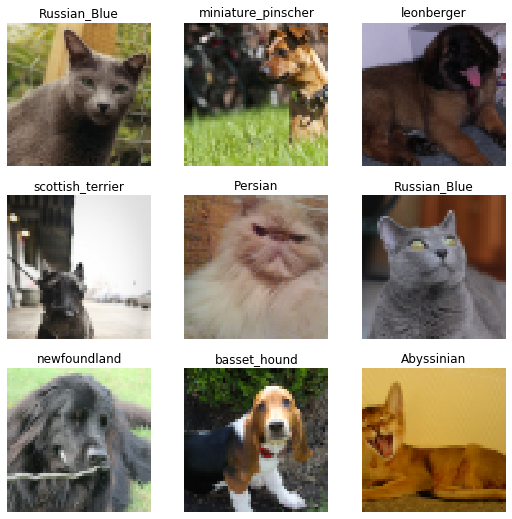

In [13]:
dls = pets.dataloaders(path/"images",bs=32)
dls.show_batch()

# Adjusted Loss Function

In [14]:
pet_type = ['cat']*12+['dog']*25



In [15]:
from torch.nn.functional import nll_loss,log_softmax

def final_loss(input, target, w=1, weight=None, size_average=None, ignore_index=-100,
                  reduce=None, reduction='mean'):
    ce1 = cross_entropy1(input, target, weight=None, size_average=None, ignore_index=-100,
                  reduce=None, reduction='mean')
    
    ce2 = cross_entropy2(input, target, weight=None, size_average=None, ignore_index=-100,
                  reduce=None, reduction='mean')
    
    #print(ce1,ce2,w1,w2)
    return w*ce1+(1-w)*ce2
    

def cross_entropy1(input, target, weight=None, size_average=None, ignore_index=-100,
                  reduce=None, reduction='mean'):
    
    input_p = torch.softmax(input,dim=-1)
    
    return nll_loss(torch.log(input_p), target, None, None, ignore_index, None, reduction)

def cross_entropy2(input, target, weight=None, size_average=None, ignore_index=-100,
                  reduce=None, reduction='mean'):
    
    input_p = torch.softmax(input,dim=1)

    
    cats = torch.sum(input_p[:,0:12],dim=1).view(input_p.shape[0],1)
    dogs = torch.sum(input_p[:,12:37],dim=1).view(input_p.shape[0],1)  
    new_input = torch.cat([cats,dogs],-1)

    
    new_target = TensorCategory((target > 11).long(),device='cuda:0')
    #print(new_target)
    #print(new_input)
    return nll_loss(torch.log(new_input), new_target, None, None, ignore_index, None, reduction)


In [16]:
from functools import partial
weights = np.array(range(0,21))/20
results = pd.DataFrame()
id_num = 1
for w in weights:
    for i in range(0,10):
        print(w)
        tmp_loss = partial(final_loss,w=w)
        learn = cnn_learner(dls, resnet18, metrics=[accuracy,accuracy_single], pretrained=True, loss_func = tmp_loss)
        learn.fine_tune(3)

        df = pd.DataFrame(learn.recorder.values)
        df.columns = learn.recorder.metric_names[1:-1]
        df['w'] = w
        df['id'] = id_num
        
        results = results.append(df)
        
        id_num = id_num + 1
        
        learn = None
        torch.cuda.empty_cache()

0.0


0.0


0.0


0.0


0.0


0.0


0.0


0.0


0.0


0.0


0.05


0.05


0.05


0.05


0.05


RuntimeError: CUDA out of memory. Tried to allocate 78.00 MiB (GPU 0; 3.82 GiB total capacity; 2.58 GiB already allocated; 36.81 MiB free; 2.60 GiB reserved in total by PyTorch)

In [ ]:
results.to_csv('results.csv')